In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import mapping
from yellowbrick.cluster import KElbowVisualizer
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import lightgbm as lgb
from skopt import BayesSearchCV
from feature_engine.selection import DropCorrelatedFeatures
from feature_engine.imputation import EndTailImputer, MeanMedianImputer
from mlxtend.evaluate.time_series import GroupTimeSeriesSplit, print_split_info
from sklearn.model_selection import TimeSeriesSplit

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, mean_absolute_error



In [70]:
def feature_engineering(dataframe, cutoff_date):
    
    #defino hasta donde es train y test
    train_data = dataframe[dataframe.index < cutoff_date]
    test_data = dataframe[dataframe.index >= cutoff_date]
    

    #Defino las columnas a transformar
    columns_to_transform = list(train_data.iloc[:,:-1].columns)
    target_column = ['height']

    # Crear el transformador ColumnTransformer
    transformers = [
        ('endtail_imputer', MeanMedianImputer(imputation_method='median'), columns_to_transform+target_column),
    ]

    preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

    # Definir el pipeline completo
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
    ])

    # Transformar los datos
    train_array_processed = pipeline.fit_transform(train_data)
    test_array_processed = pipeline.transform(test_data)
    
    # Convertir los datos procesados en DataFrame
    train_data_processed = pd.DataFrame(train_array_processed, columns=columns_to_transform+target_column, index=train_data.index)
    test_data_processed = pd.DataFrame(test_array_processed, columns=columns_to_transform+target_column, index=test_data.index)
    

    # Separar en características (X) y objetivo (y)
    X_train, y_train = train_data_processed.iloc[:, :-1], train_data_processed.iloc[:, -1]
    X_test, y_test = test_data_processed.iloc[:, :-1], test_data_processed.iloc[:, -1]

    return X_train, y_train, X_test, y_test
    
def train_test_lightgbm_regression(X_train, y_train):
    """
    Train a LightGBM regression model using a train-test split, perform grid search for hyperparameter tuning,
    and perform time series cross-validation to evaluate model performance.

    Args:
        dataframe (pd.DataFrame): The DataFrame containing features and target variable.
        date (str): The date used as cutoff to define train and test subsamples. The date is the starting date in the test dataset.
        metric (callable): The metric to optimize during grid search and model evaluation.

    Returns:
        tuple: A tuple containing the best hyperparameters, the performance scores, and the trained model.

    """

    model = lgb.LGBMRegressor()

    # Grid search for hyperparameter tuning
    param_space = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5],
    'min_child_samples': [20, 50, 100],
    'random_state': [42, 60, 8888, 1]
    }   

    #Define the k-folds with TimeSeriesSplit
    #tscv = TimeSeriesSplit(int(len(X_train)/365))
    
    cv = GroupTimeSeriesSplit(
        test_size = 365,
        train_size = 365*3, 
        gap_size = 0, 
        shift_size = 365).split(X_train, y_train,list(X_train.index))
    
    def custom_metric(y_true, y_pred):
    # Por ejemplo, puedes usar el error cuadrático medio (MSE) como métrica
        mse = mean_squared_error(y_true, y_pred)
    # Retornar la métrica que deseas optimizar (por ejemplo, el inverso del MSE)
        return -mse
    
    custom_scorer = make_scorer(custom_metric, greater_is_better=True)


    #Intances the cross validator
    bayes_cv = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=50,
    cv=cv,
    scoring=custom_scorer,  # Usar TimeSeriesSplit para validación cruzada
    n_jobs=-1,
    return_train_score=True,
    verbose=1,
    refit=False
    )
    #Train my optimizer
    bayes_cv.fit(X_train, y_train)

    cv_result = pd.DataFrame(bayes_cv.cv_results_).sort_values(
        'rank_test_score', ascending=True
    )
    cv_result[['mean_fit_time',
               'mean_train_score',
                 'std_train_score',
                 'rank_train_score',
                 'mean_test_score',
                 'std_test_score',
                 'rank_test_score'
                 ]]

    #Catch the best params
    best_params = bayes_cv.best_params_
    best_score = bayes_cv.best_score_

    # Train the model with the best hyperparameters
    model = lgb.LGBMRegressor(**best_params)
    model.fit(X_train, y_train)

    # Creating the result dictionary
    result = {
        'best_params': best_params,
        'best_score': best_score,
        'model': model
    }

    return result, cv_result


def plot_prediction(model, X_train, y_train, X_test, y_test):
    """
    Plot the predictions of a regression model along with the test set.

    Args:
        model: The trained regression model.
        X_test (pd.DataFrame): The feature values of the test set.
        y_test (pd.Series): The actual target values of the test set.

    Returns:
        None
    """
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    dict_params = model.get_params()
    dict_params['objective'] = 'quantile'

    lower = lgb.LGBMRegressor(**dict_params, alpha=1-0.95)
    lower.fit(X_train_cleaned[features], y_train)
    lower_pred = lower.predict(X_test_cleaned[features])

    
    upper = lgb.LGBMRegressor(**dict_params, alpha=0.95)
    upper.fit(X_train_cleaned[features], y_train)
    upper_pred = upper.predict(X_test_cleaned[features])

    plt.figure(figsize=(10, 6))
    plt.plot(y_train.index, y_train, c='green', label='Actual_train')
    plt.plot(y_train.index, y_pred_train, c='red', label='Predicted_train')
    plt.plot(y_test.index, y_test, c='blue', label='Actual_test')
    plt.plot(y_test.index, y_pred_test, c='orange', label='Predicted_test')
    plt.fill_between(y_test.index, lower_pred, upper_pred, color='orange', alpha=0.3, label='Intervalo 5-95')
    plt.xlabel('Time')
    plt.ylabel('Target')
    plt.title('Prediction vs Actual')
    plt.legend()
    plt.show()

def add_lagged_columns(dataframe, lag_values):
    """
    Lag the columns in the DataFrame based on the specified lag values and add them as new columns.

    Args:
        dataframe (pd.DataFrame): The DataFrame containing the columns to be lagged.
        lag_values (list): The list of lag values to apply.

    Returns:
        pd.DataFrame: The DataFrame with lagged columns added.

    """
    lagged_dataframe = dataframe.copy()
    for column in dataframe.columns:
        for lag in lag_values:
            lagged_column = dataframe[column].shift(lag)
            lagged_dataframe[f"{column}_lag_{lag}"] = lagged_column

    return lagged_dataframe


In [83]:
df = pd.read_csv(ff'{workspace}tesis/datos/procesados/features_new.csv')
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')
river_height_data = xr.open_dataset(f'{workspace}tesis/datos/procesados/00-datos_prod/03-puertostafe20072023_ok_.nc')

# df_target = river_height_data.santotome.fillna(river_height_data.santotome.mean(dim='time')).to_dataframe()[['santotome']]
df_target = river_height_data.to_dataframe()[['height']]
df_target = df_target.reset_index()
df_target['time'] = pd.to_datetime(df_target['time'])
df_target = df_target.set_index('time')

In [85]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
chirps_1,5844.0,1.828075,4.682185,0.000000,0.000000,0.044378,1.044494,52.867428
chirps_2,5844.0,2.805626,5.804951,0.000000,0.000000,0.257697,2.589067,56.957027
chirps_3,5844.0,2.448562,5.055038,0.000000,0.000000,0.265471,2.197984,58.062920
chirps_4,5844.0,2.099588,4.675954,0.000000,0.000000,0.137888,1.715530,57.371845
mswep_1,5844.0,2.035115,4.619755,0.000000,0.000000,0.119023,1.596540,55.310062
mswep_2,5844.0,2.425904,5.005119,0.000000,0.000000,0.253697,2.203745,57.113100
mswep_3,5844.0,2.804309,5.802835,0.000000,0.000000,0.257780,2.594434,56.913807
mswep_4,5844.0,1.792427,4.633436,0.000000,0.000000,0.036951,1.009169,52.053320
soil_1,5844.0,4.324472,0.558726,2.071259,4.053492,4.390118,4.675270,6.059635
soil_2,5844.0,5.589507,0.585645,2.925908,5.318335,5.674709,5.955413,7.242019


In [72]:
lags = [i for i in range(-150, 0)]

df_final = pd.concat([add_lagged_columns(df, lags),df_target], axis=1)
df_final_wo_na = df_final[:min(lags)]

/var/folders/8z/vjxlhv2s499b46l6s62czlmm0000gn/T/ipykernel_60852/2211909724.py:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_dataframe[f"{column}_lag_{lag}"] = lagged_column
/var/folders/8z/vjxlhv2s499b46l6s62czlmm0000gn/T/ipykernel_60852/2211909724.py:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_dataframe[f"{column}_lag_{lag}"] = lagged_column
/var/folders/8z/vjxlhv2s499b46l6s62czlmm0000gn/T/ipykernel_60852/2211909724.py:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

In [73]:
features = df_final_wo_na.columns
features = features.drop('height')

In [74]:
# Llamar a la función y desempaquetar los resultado
X_train, y_train, X_test, y_test = feature_engineering(df_final_wo_na, '2023-01-01')

In [75]:
cv_args = {"test_size":365, 'train_size':365, "gap_size":0, "shift_size":365}
print_split_info(X_train,y_train, list(X_train.index),**cv_args)

Train indices: [  4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246

In [76]:
dcf = DropCorrelatedFeatures(threshold=0.6)
X_train_cleaned = dcf.fit_transform(X_train)
X_test_cleaned = dcf.transform(X_test)

In [77]:
len(list(X_train_cleaned.columns))

482

In [78]:
features = X_train_cleaned.columns

In [66]:
output, cv_results = train_test_lightgbm_regression(X_train_cleaned, y_train)

Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 13 folds for eac

/Users/santiagogimenez/miniconda3/envs/tesis-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 13 folds for each of 1 candidates, totalling 13 fits


/Users/santiagogimenez/miniconda3/envs/tesis-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 13 folds for each of 1 candidates, totalling 13 fits


In [67]:
output

{'best_params': OrderedDict([('boosting_type', 'dart'),
              ('colsample_bytree', 1.0),
              ('learning_rate', 0.01),
              ('min_child_samples', 20),
              ('n_estimators', 100),
              ('num_leaves', 20),
              ('random_state', 60),
              ('reg_alpha', 0.1),
              ('reg_lambda', 0.0),
              ('subsample', 0.8)]),
 'best_score': 4.418963751719657,
 'model': LGBMRegressor(boosting_type='dart', learning_rate=0.01, num_leaves=20,
               random_state=60, reg_alpha=0.1, subsample=0.8)}

In [68]:
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boosting_type,param_colsample_bytree,param_learning_rate,param_min_child_samples,param_n_estimators,param_num_leaves,...,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,split12_train_score,mean_train_score,std_train_score,rank_train_score
43,4.748028,1.683266,0.018458,0.009909,dart,1.0,0.01,20,100,20,...,4.739697,5.912146,5.846143,5.696666,4.692083,3.672582,2.735122,4.451805,0.908913,20
29,2.406706,0.884530,0.014991,0.009162,dart,1.0,0.01,20,100,40,...,4.754742,5.925340,5.866208,5.710402,4.711583,3.688765,2.740939,4.464258,0.911444,16
38,3.677695,1.327044,0.012496,0.004869,dart,1.0,0.01,20,100,20,...,4.742679,5.915575,5.849948,5.700607,4.694623,3.674983,2.736214,4.454425,0.909606,19
47,2.889931,0.953595,0.013202,0.004480,dart,1.0,0.01,20,100,20,...,4.755986,5.927943,5.863472,5.713679,4.707887,3.684628,2.739086,4.465584,0.911662,15
49,4.137137,1.492760,0.017867,0.009845,dart,1.0,0.01,20,100,20,...,4.745289,5.918112,5.852824,5.703259,4.697125,3.677370,2.736901,4.456500,0.910064,17
34,3.590681,1.256979,0.012492,0.005134,dart,1.0,0.01,20,100,20,...,4.745289,5.918112,5.852824,5.703259,4.697125,3.677370,2.736901,4.456500,0.910064,17
37,3.754086,1.297367,0.011365,0.003041,dart,1.0,0.01,20,100,20,...,4.737058,5.909853,5.843078,5.694408,4.689885,3.670353,2.734430,4.449673,0.908519,21
33,2.905772,1.009638,0.017627,0.012387,dart,1.0,0.01,20,100,40,...,4.759712,5.928488,5.870253,5.714178,4.714078,3.690310,2.741302,4.467472,0.912087,13
42,2.634186,0.890186,0.014772,0.005849,dart,1.0,0.01,20,100,20,...,4.763151,5.936666,5.876219,5.726356,4.713091,3.688765,2.740939,4.472198,0.914242,9
36,2.361622,0.799987,0.011811,0.003827,dart,1.0,0.01,20,100,20,...,4.763151,5.936666,5.876219,5.726356,4.713091,3.688765,2.740939,4.472198,0.914242,9


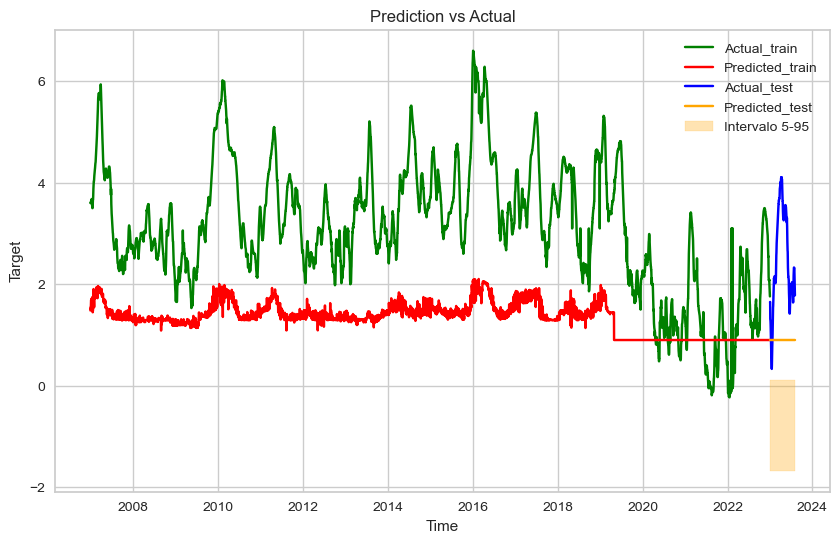

In [80]:
# model_selected = lgb.LGBMRegressor(**dict(output['best_params']))
# model_selected.fit(X_train_cleaned, y_train)

model = lgb.LGBMRegressor(**dict(output['best_params']))
model.fit(X_train_cleaned, y_train)

plot_prediction(model, X_train_cleaned, y_train, X_test_cleaned, y_test)


In [60]:
print('el error cuadrático medio en train es: ', np.sqrt(mean_squared_error(y_train,model.predict(X_train_cleaned))))
print('el error absoluto medio en train es: ', mean_absolute_error(y_train,model.predict(X_train_cleaned)))
print('el error cuadrático medio en test es: ', np.sqrt(mean_squared_error(y_test,model.predict(X_test_cleaned))))
print('el error absoluto medio en test es: ', mean_absolute_error(y_test,model.predict(X_test_cleaned)))

el error cuadrático medio en train es:  0.6346512988096241
el error absoluto medio en train es:  0.43929892517596325
el error cuadrático medio en test es:  1.3442910710477867
el error absoluto medio en test es:  1.091919615144962


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

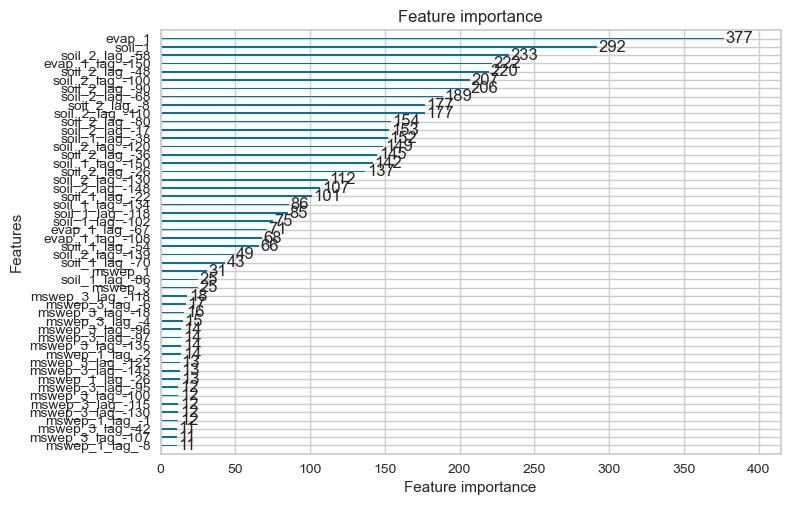

In [61]:
lgb.plot_importance(model, max_num_features=50)

In [62]:
feature_importance = model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_cleaned.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
4,evap_1,377
3,soil_1,292
473,soil_2_lag_-58,233
479,evap_1_lag_-150,222
474,soil_2_lag_-48,220
...,...,...
395,mswep_3_lag_-60,0
236,mswep_1_lag_-69,0
392,mswep_3_lag_-63,0
243,mswep_1_lag_-62,0


In [63]:
features = list(importance_df[:50]['Feature'])
len(features)

50

## Quedandome con las primeras 50 variables del modelo anterior

In [135]:
output, cv_results = train_test_lightgbm_regression(X_train_cleaned[features], y_train, mean_squared_error)

Fitting 8 folds for each of 1 candidates, totalling 8 fits
Fitting 8 folds for each of 1 candidates, totalling 8 fits
Fitting 8 folds for each of 1 candidates, totalling 8 fits
Fitting 8 folds for each of 1 candidates, totalling 8 fits
Fitting 8 folds for each of 1 candidates, totalling 8 fits
Fitting 8 folds for each of 1 candidates, totalling 8 fits
Fitting 8 folds for each of 1 candidates, totalling 8 fits
Fitting 8 folds for each of 1 candidates, totalling 8 fits
Fitting 8 folds for each of 1 candidates, totalling 8 fits
Fitting 8 folds for each of 1 candidates, totalling 8 fits
Fitting 8 folds for each of 1 candidates, totalling 8 fits
Fitting 8 folds for each of 1 candidates, totalling 8 fits
Fitting 8 folds for each of 1 candidates, totalling 8 fits
Fitting 8 folds for each of 1 candidates, totalling 8 fits
Fitting 8 folds for each of 1 candidates, totalling 8 fits
Fitting 8 folds for each of 1 candidates, totalling 8 fits
Fitting 8 folds for each of 1 candidates, totalling 8 fi

In [136]:
output

{'best_params': OrderedDict([('boosting_type', 'gbdt'),
              ('colsample_bytree', 0.9),
              ('learning_rate', 0.01),
              ('min_child_samples', 50),
              ('n_estimators', 200),
              ('num_leaves', 20),
              ('random_state', 60),
              ('reg_alpha', 0.5),
              ('reg_lambda', 0.0),
              ('subsample', 1.0)]),
 'best_score': -0.751633004397539,
 'model': LGBMRegressor(colsample_bytree=0.9, learning_rate=0.01, min_child_samples=50,
               n_estimators=200, num_leaves=20, random_state=60, reg_alpha=0.5)}

In [137]:
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boosting_type,param_colsample_bytree,param_learning_rate,param_min_child_samples,param_n_estimators,param_num_leaves,...,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,mean_train_score,std_train_score,rank_train_score
14,0.849405,0.068307,0.014844,0.001344,gbdt,0.9,0.01,50,200,30,...,-0.081445,-0.106312,-0.136527,-0.112054,-0.126237,-0.134850,-0.155100,-0.117516,0.023721,28
11,0.907639,0.047643,0.015342,0.001951,gbdt,0.9,0.01,50,200,20,...,-0.081445,-0.106312,-0.136527,-0.112054,-0.126237,-0.134850,-0.155100,-0.117516,0.023721,28
39,1.649761,0.117941,0.018701,0.002734,gbdt,0.9,0.01,20,200,40,...,-0.050961,-0.064324,-0.075405,-0.050955,-0.054639,-0.061974,-0.084284,-0.061486,0.011925,17
45,1.518403,0.116224,0.016981,0.002563,gbdt,0.9,0.01,20,200,30,...,-0.052964,-0.066894,-0.079372,-0.058204,-0.055575,-0.068903,-0.090337,-0.065595,0.012749,19
48,0.788376,0.042220,0.012424,0.001949,gbdt,1.0,0.01,50,200,20,...,-0.082148,-0.106740,-0.137289,-0.111851,-0.125936,-0.134783,-0.155532,-0.117976,0.023415,32
17,0.868344,0.051514,0.014383,0.001003,gbdt,0.8,0.01,50,200,30,...,-0.081669,-0.107256,-0.137494,-0.112996,-0.127003,-0.134468,-0.156681,-0.118206,0.023936,33
6,0.867535,0.054826,0.020604,0.006977,gbdt,0.9,0.01,50,200,20,...,-0.081916,-0.106180,-0.136293,-0.112809,-0.126428,-0.134476,-0.154918,-0.117589,0.023522,30
32,0.662286,0.047299,0.014579,0.002499,gbdt,0.8,0.01,50,200,40,...,-0.078957,-0.103585,-0.133643,-0.109177,-0.123767,-0.131162,-0.151382,-0.114699,0.023231,25
44,0.753320,0.050234,0.012511,0.001042,gbdt,0.9,0.01,50,200,40,...,-0.082099,-0.106087,-0.137423,-0.112725,-0.126288,-0.135395,-0.154684,-0.117875,0.023545,31
41,0.749254,0.040630,0.012691,0.001657,gbdt,0.9,0.01,50,200,40,...,-0.083115,-0.107383,-0.137135,-0.113124,-0.127907,-0.135249,-0.155920,-0.118663,0.023354,34


In [143]:
dict(output['best_params'])

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.9,
 'learning_rate': 0.01,
 'min_child_samples': 50,
 'n_estimators': 200,
 'num_leaves': 20,
 'random_state': 60,
 'reg_alpha': 0.5,
 'reg_lambda': 0.0,
 'subsample': 1.0}

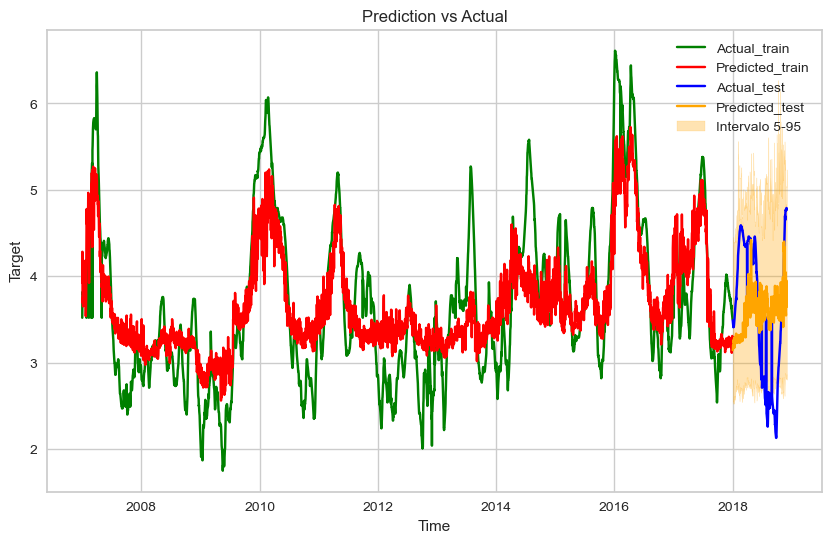

In [146]:
# model_selected = lgb.LGBMRegressor(**dict(output['best_params']))
# model_selected.fit(X_train_cleaned, y_train)

model = lgb.LGBMRegressor(**dict(output['best_params']))
model.fit(X_train_cleaned[features], y_train)

plot_prediction(model, X_train_cleaned[features], y_train, X_test_cleaned[features], y_test)


In [147]:
print('el error cuadrático medio en train es: ', np.sqrt(mean_squared_error(y_train,model.predict(X_train_cleaned[features]))))
print('el error absoluto medio en train es: ', mean_absolute_error(y_train,model.predict(X_train_cleaned[features])))
print('el error cuadrático medio en test es: ', np.sqrt(mean_squared_error(y_test,model.predict(X_test_cleaned[features]))))
print('el error absoluto medio en test es: ', mean_absolute_error(y_test,model.predict(X_test_cleaned[features])))

el error cuadrático medio en train es:  0.5336149766297571
el error absoluto medio en train es:  0.43511130259049235
el error cuadrático medio en test es:  0.85882447086554
el error absoluto medio en test es:  0.7633522481138962


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

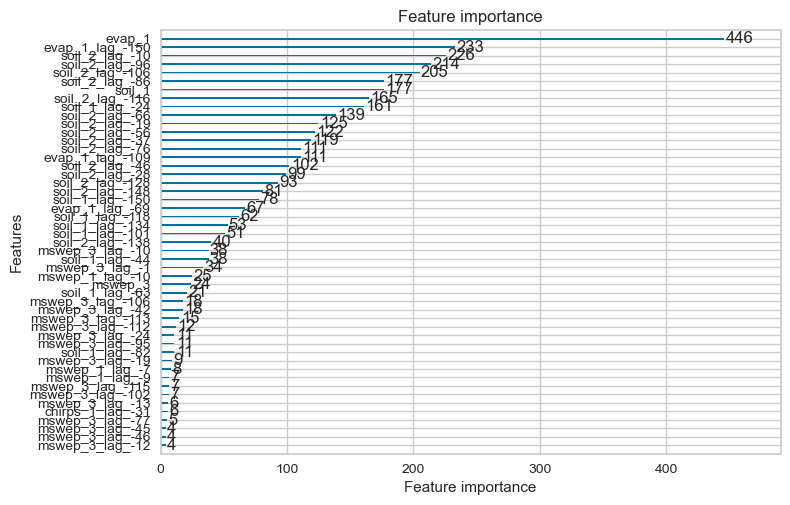

In [148]:
lgb.plot_importance(model, max_num_features=50)